In [1]:
# Install / Imports
!pip -q install datasets scikit-learn
!pip -q install datasets scikit-learn matplotlib



import re
import math
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from datasets import load_dataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


c:\Users\sarav\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Reproducibility + Device
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cpu


In [3]:
# SNIPS load dataset and intent classification
ds = load_dataset("DeepPavlov/snips", "default")

print(ds)
print("Train size:", len(ds["train"]), "Test size:", len(ds["test"]))
print("Example:", ds["train"][0])



DatasetDict({
    train: Dataset({
        features: ['utterance', 'label'],
        num_rows: 13084
    })
    test: Dataset({
        features: ['utterance', 'label'],
        num_rows: 1400
    })
})
Train size: 13084 Test size: 1400
Example: {'utterance': 'Add Don and Sherri to my Meditate to Sounds of Nature playlist', 'label': 0}


In [4]:
# Text cleaning + tokenization
def clean_text(s: str) -> str:
    s = s.lower().strip()
    s = re.sub(r"\s+", " ", s)
    return s

def tokenize(s: str):
    return clean_text(s).split()

In [5]:
# Build vocabulary
from collections import Counter

MIN_FREQ = 1          # keep 1 to avoid dropping rare words
PAD_TOKEN = "<pad>"
UNK_TOKEN = "<unk>"

counter = Counter()
for x in ds["train"]["utterance"]:
    counter.update(tokenize(x))

itos = [PAD_TOKEN, UNK_TOKEN]  # index -> token
for w, c in counter.items():
    if c >= MIN_FREQ:
        itos.append(w)

stoi = {w:i for i,w in enumerate(itos)}

pad_id = stoi[PAD_TOKEN]
unk_id = stoi[UNK_TOKEN]

print("Vocab size:", len(itos), "| pad_id:", pad_id, "| unk_id:", unk_id)


Vocab size: 11695 | pad_id: 0 | unk_id: 1


In [6]:
#Encode sequences + choose max_len (pad/truncate)
MAX_LEN = 30

def encode(tokens):
    ids = [stoi.get(t, unk_id) for t in tokens]
    return ids

def pad_trunc(ids, max_len=MAX_LEN):
    if len(ids) >= max_len:
        return ids[:max_len], max_len
    else:
        return ids + [pad_id]*(max_len - len(ids)), len(ids)

# label info
num_classes = len(set(ds["train"]["label"]))
print("Num classes:", num_classes)


Num classes: 7


In [7]:
# Pytorch Dataset
class SnipsDataset(Dataset):
    def __init__(self, split):
        self.texts = ds[split]["utterance"]
        self.labels = ds[split]["label"]

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        tokens = tokenize(self.texts[idx])
        ids = encode(tokens)
        x, length = pad_trunc(ids, MAX_LEN)
        y = self.labels[idx]
        return torch.tensor(x, dtype=torch.long), torch.tensor(length, dtype=torch.long), torch.tensor(y, dtype=torch.long)

train_data = SnipsDataset("train")
test_data  = SnipsDataset("test")


In [8]:
# DataLoader (Iteration 1: no packing, simple batch)
BATCH1 = 16

def collate_basic(batch):
    xs, lens, ys = zip(*batch)
    xs = torch.stack(xs, dim=0)        # (B, T)
    lens = torch.stack(lens, dim=0)    # (B,)
    ys = torch.stack(ys, dim=0)        # (B,)
    return xs, lens, ys

train_loader1 = DataLoader(train_data, batch_size=BATCH1, shuffle=True, collate_fn=collate_basic)
test_loader1  = DataLoader(test_data,  batch_size=BATCH1, shuffle=False, collate_fn=collate_basic)


In [9]:
# Model (Iteration 1)
class RNNClassifierBasic(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, num_classes, pad_id):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_id)
        self.rnn = nn.RNN(emb_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x, lengths):
        # x: (B,T)
        emb = self.embedding(x)                # (B,T,D)
        out, h = self.rnn(emb)                 # out: (B,T,H), h: (1,B,H)

        # take last *real* timestep using lengths-1
        idx = (lengths - 1).clamp(min=0)       # (B,)
        idx = idx.view(-1, 1, 1).expand(-1, 1, out.size(2))  # (B,1,H)
        last = out.gather(1, idx).squeeze(1)   # (B,H)

        logits = self.fc(last)                 # (B,C)
        return logits

model1 = RNNClassifierBasic(len(itos), emb_dim=64, hidden_dim=64, num_classes=num_classes, pad_id=pad_id).to(device)
print(model1)


RNNClassifierBasic(
  (embedding): Embedding(11695, 64, padding_idx=0)
  (rnn): RNN(64, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=7, bias=True)
)


In [10]:
# Train / Eval loops + History
def accuracy_from_logits(logits, y):
    preds = torch.argmax(logits, dim=1)
    return (preds == y).float().mean().item()

def train_one_epoch_basic(model, loader, optimizer, criterion):
    model.train()
    losses, accs = [], []
    for x, lengths, y in loader:
        x, lengths, y = x.to(device), lengths.to(device), y.to(device)

        optimizer.zero_grad()
        logits = model(x, lengths)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        accs.append(accuracy_from_logits(logits, y))

    return float(np.mean(losses)), float(np.mean(accs))

@torch.no_grad()
def eval_one_epoch_basic(model, loader, criterion):
    model.eval()
    losses, accs = [], []
    all_true, all_pred = [], []
    for x, lengths, y in loader:
        x, lengths, y = x.to(device), lengths.to(device), y.to(device)
        logits = model(x, lengths)
        loss = criterion(logits, y)

        preds = torch.argmax(logits, dim=1)
        losses.append(loss.item())
        accs.append((preds == y).float().mean().item())

        all_true.extend(y.cpu().numpy().tolist())
        all_pred.extend(preds.cpu().numpy().tolist())

    return float(np.mean(losses)), float(np.mean(accs)), all_true, all_pred

def plot_history(hist, title):
    epochs = list(range(1, len(hist["train_loss"]) + 1))

    plt.figure()
    plt.plot(epochs, hist["train_loss"], label="train loss")
    plt.plot(epochs, hist["val_loss"], label="val loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{title} - Loss")
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(epochs, hist["train_acc"], label="train acc")
    plt.plot(epochs, hist["val_acc"], label="val acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{title} - Accuracy")
    plt.legend()
    plt.show()


Epoch 01 | train loss 0.5792 acc 0.8177 | val loss 0.2475 acc 0.9254
Epoch 02 | train loss 0.1645 acc 0.9522 | val loss 0.1685 acc 0.9567
Epoch 03 | train loss 0.1026 acc 0.9699 | val loss 0.1728 acc 0.9467
Epoch 04 | train loss 0.0707 acc 0.9790 | val loss 0.1143 acc 0.9695
Epoch 05 | train loss 0.0448 acc 0.9877 | val loss 0.1538 acc 0.9545
Epoch 06 | train loss 0.0385 acc 0.9896 | val loss 0.1132 acc 0.9730


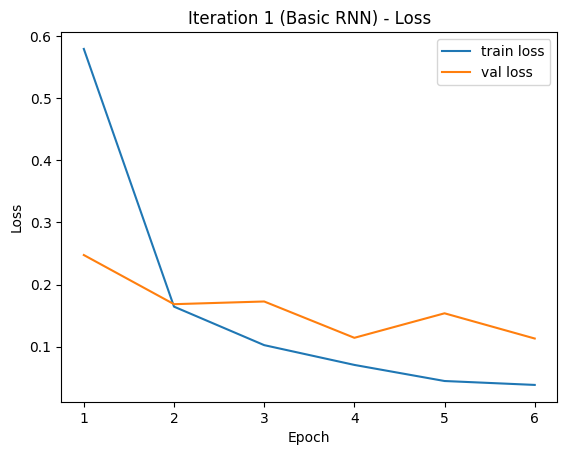

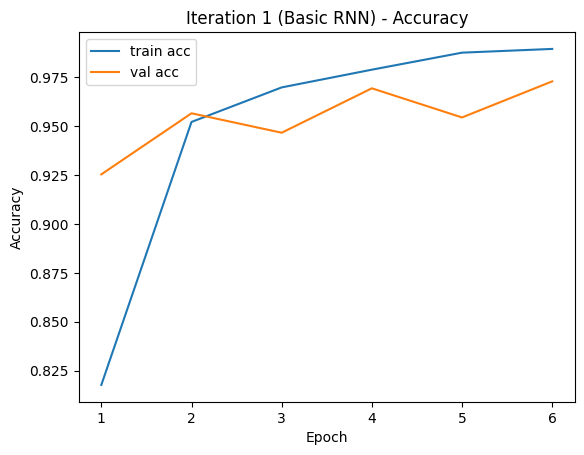

In [11]:
# Train Iteration 1
EPOCHS1 = 6
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=1e-3)

history1 = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

for epoch in range(1, EPOCHS1 + 1):
    tr_loss, tr_acc = train_one_epoch_basic(model1, train_loader1, optimizer, criterion)
    va_loss, va_acc, _, _ = eval_one_epoch_basic(model1, test_loader1, criterion)

    history1["train_loss"].append(tr_loss)
    history1["train_acc"].append(tr_acc)
    history1["val_loss"].append(va_loss)
    history1["val_acc"].append(va_acc)

    print(f"Epoch {epoch:02d} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | val loss {va_loss:.4f} acc {va_acc:.4f}")

plot_history(history1, "Iteration 1 (Basic RNN)")


Label names not available; using numeric labels.

Iteration 1 Accuracy: 0.9728571428571429

Iteration 1 Classification Report:

              precision    recall  f1-score   support

           0     0.9901    1.0000    0.9950       200
           1     0.9800    0.9800    0.9800       200
           2     0.9795    0.9550    0.9671       200
           3     0.9701    0.9750    0.9726       200
           4     0.9662    1.0000    0.9828       200
           5     0.9403    0.9450    0.9426       200
           6     0.9845    0.9550    0.9695       200

    accuracy                         0.9729      1400
   macro avg     0.9730    0.9729    0.9728      1400
weighted avg     0.9730    0.9729    0.9728      1400


Iteration 1 Confusion Matrix:
 [[200   0   0   0   0   0   0]
 [  1 196   1   0   2   0   0]
 [  0   4 191   1   1   2   1]
 [  1   0   0 195   0   4   0]
 [  0   0   0   0 200   0   0]
 [  0   0   0   5   4 189   2]
 [  0   0   3   0   0   6 191]]


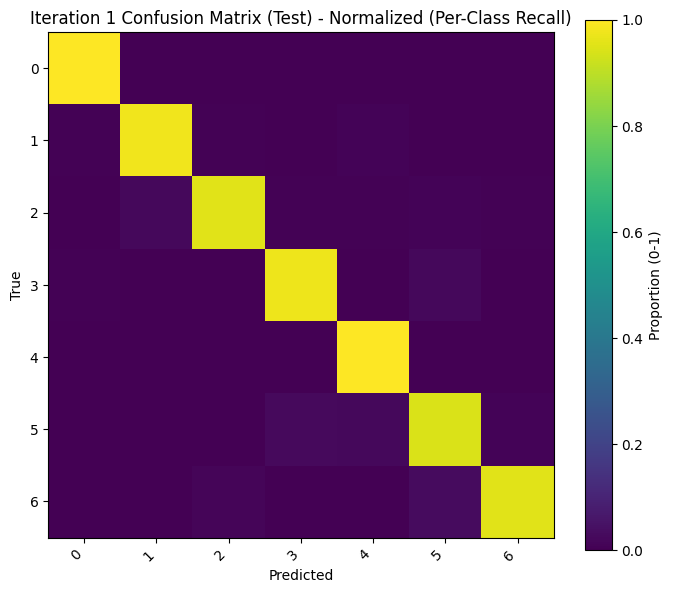


Iteration 1 Sample misclassifications:
- True=1 (1) | Pred=0 (0) | Text: Anything close to Smith-9th St that can seat two people about one minute from now ?
- True=1 (1) | Pred=4 (4) | Text: stacy watson and adriana want to go to the best osteria in Hallowell Minnesota this afternoon
- True=1 (1) | Pred=4 (4) | Text: I want to book Oregon Electric Station in North City .
- True=1 (1) | Pred=2 (2) | Text: Can you book me a table at Windows on the World in Cokeville , MI ?
- True=2 (2) | Pred=1 (1) | Text: Will the wind die down at my current location by supper time?
- True=2 (2) | Pred=1 (1) | Text: show fog conditions at 7 am in NH
- True=2 (2) | Pred=1 (1) | Text: I want to book a restaurant in Neshanic Station Nigeria for 061813 pm
- True=2 (2) | Pred=1 (1) | Text: Book a restaurant 1 hour from now in Dorchester Shores Reservation
- True=2 (2) | Pred=5 (5) | Text: What's the forecase for Inverness on February 5th, 2031 ?
- True=2 (2) | Pred=6 (6) | Text: When is sunrise for AR


In [12]:

# Iteration 1 evaluation: report + confusion matrix + misclassifications

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# Build label names if available (otherwise numeric 0..C-1)
label_names = None
try:
    if "label" in ds["train"].features and hasattr(ds["train"].features["label"], "names"):
        label_names = ds["train"].features["label"].names
except:
    pass

if label_names is None:
    label_names = [str(i) for i in range(num_classes)]
    print("Label names not available; using numeric labels.")
else:
    print("Label names:", label_names)

# Raw test texts (same order as ds["test"])
test_texts = list(ds["test"]["utterance"])

# Predict on test set (Iteration 1 loader is not sorted, so order matches ds["test"])
_, _, y_true1, y_pred1 = eval_one_epoch_basic(model1, test_loader1, criterion)

print("\nIteration 1 Accuracy:", accuracy_score(y_true1, y_pred1))
print("\nIteration 1 Classification Report:\n")
print(classification_report(y_true1, y_pred1, target_names=label_names, digits=4))

cm1 = confusion_matrix(y_true1, y_pred1)
print("\nIteration 1 Confusion Matrix:\n", cm1)

# Plot normalized confusion matrix (per-class recall)
cm1_norm = cm1.astype(float) / cm1.sum(axis=1, keepdims=True)

plt.figure(figsize=(7,6))
plt.imshow(cm1_norm, vmin=0, vmax=1, interpolation="nearest")
plt.title("Iteration 1 Confusion Matrix (Test) - Normalized (Per-Class Recall)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(range(num_classes), label_names, rotation=45, ha="right")
plt.yticks(range(num_classes), label_names)
plt.colorbar(label="Proportion (0-1)")
plt.tight_layout()
plt.show()

# Misclassification samples
wrong_idx = np.where(np.array(y_true1) != np.array(y_pred1))[0][:10]
print("\nIteration 1 Sample misclassifications:")
for i in wrong_idx:
    i = int(i)
    print(f"- True={y_true1[i]} ({label_names[y_true1[i]]}) | Pred={y_pred1[i]} ({label_names[y_pred1[i]]}) | Text: {test_texts[i][:120]}")


In [13]:
# Iteration 2 Pad+Pack collate
def pad_and_pack(batch):
    xs, lens, ys = zip(*batch)
    xs = torch.stack(xs, dim=0)           # already padded to MAX_LEN
    lens = torch.stack(lens, dim=0)
    ys = torch.stack(ys, dim=0)

    # sort by length (optional, but good practice)
    lens_sorted, sort_idx = torch.sort(lens, descending=True)
    xs_sorted = xs[sort_idx]
    ys_sorted = ys[sort_idx]

    return xs_sorted, lens_sorted, ys_sorted, sort_idx

BATCH2 = 32
train_loader2 = DataLoader(train_data, batch_size=BATCH2, shuffle=True, collate_fn=pad_and_pack)
test_loader2  = DataLoader(test_data,  batch_size=BATCH2, shuffle=False, collate_fn=pad_and_pack)


In [14]:
# Model with packing
class RNNClassifierPacked(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, num_classes, pad_id, num_layers=2, dropout=0.2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_id)
        self.rnn = nn.RNN(
            input_size=emb_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x, lengths):
        emb = self.embedding(x)  # (B,T,D)

        packed = nn.utils.rnn.pack_padded_sequence(
            emb, lengths.cpu(), batch_first=True, enforce_sorted=True
        )
        packed_out, h = self.rnn(packed)

        # h: (num_layers, B, H) -> use last layer hidden
        last_h = h[-1]  # (B,H)
        logits = self.fc(last_h)
        return logits

model2 = RNNClassifierPacked(len(itos), emb_dim=128, hidden_dim=128, num_classes=num_classes, pad_id=pad_id,
                             num_layers=2, dropout=0.2).to(device)
print(model2)


RNNClassifierPacked(
  (embedding): Embedding(11695, 128, padding_idx=0)
  (rnn): RNN(128, 128, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=7, bias=True)
)


In [15]:
# Train/Eval loops for packed loaders
def train_one_epoch_packed(model, loader, optimizer, criterion):
    model.train()
    losses, accs = [], []
    for x, lengths, y, _sort_idx in loader:
        x, lengths, y = x.to(device), lengths.to(device), y.to(device)

        optimizer.zero_grad()
        logits = model(x, lengths)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        accs.append(accuracy_from_logits(logits, y))
    return float(np.mean(losses)), float(np.mean(accs))

@torch.no_grad()
def eval_one_epoch_packed(model, loader, criterion):
    model.eval()
    losses, accs = [], []
    all_true, all_pred, all_text = [], [], []

    for x, lengths, y, sort_idx in loader:
        x, lengths, y = x.to(device), lengths.to(device), y.to(device)
        logits = model(x, lengths)
        loss = criterion(logits, y)

        preds = torch.argmax(logits, dim=1)

        losses.append(loss.item())
        accs.append((preds == y).float().mean().item())

        all_true.extend(y.cpu().numpy().tolist())
        all_pred.extend(preds.cpu().numpy().tolist())

    return float(np.mean(losses)), float(np.mean(accs)), all_true, all_pred


Epoch 01 | train loss 0.4367 acc 0.8632 | val loss 0.1978 acc 0.9380 | best 0.9380
Epoch 02 | train loss 0.1258 acc 0.9630 | val loss 0.1311 acc 0.9631 | best 0.9631
Epoch 03 | train loss 0.0920 acc 0.9723 | val loss 0.1031 acc 0.9709 | best 0.9709
Epoch 04 | train loss 0.0486 acc 0.9850 | val loss 0.0852 acc 0.9744 | best 0.9744
Epoch 05 | train loss 0.0317 acc 0.9904 | val loss 0.0792 acc 0.9751 | best 0.9751
Epoch 06 | train loss 0.0233 acc 0.9932 | val loss 0.0940 acc 0.9742 | best 0.9751
Epoch 07 | train loss 0.0164 acc 0.9956 | val loss 0.0777 acc 0.9808 | best 0.9808
Epoch 08 | train loss 0.0116 acc 0.9976 | val loss 0.0638 acc 0.9830 | best 0.9830
Epoch 09 | train loss 0.0099 acc 0.9976 | val loss 0.0664 acc 0.9822 | best 0.9830
Epoch 10 | train loss 0.0081 acc 0.9984 | val loss 0.0699 acc 0.9801 | best 0.9830


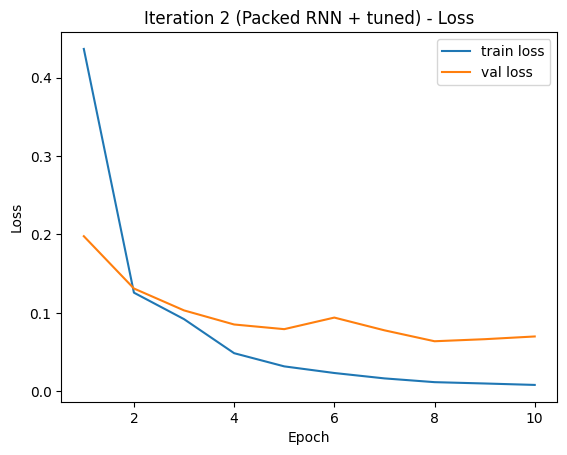

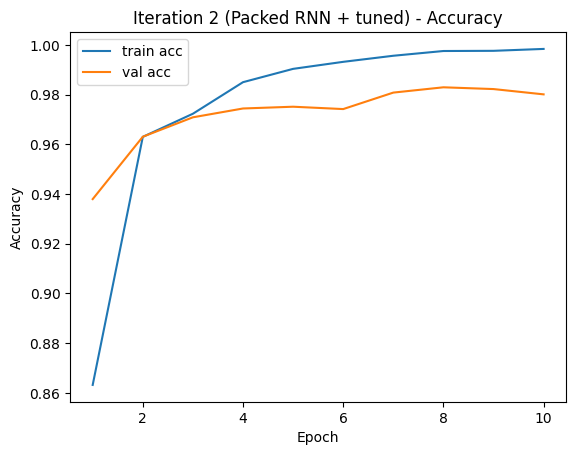

In [16]:
# Train Iteration 2 + curves
EPOCHS2 = 10
criterion2 = nn.CrossEntropyLoss()

optimizer2 = torch.optim.Adam(model2.parameters(), lr=8e-4, weight_decay=1e-5)
scheduler2 = torch.optim.lr_scheduler.StepLR(optimizer2, step_size=3, gamma=0.5)

history2 = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

best_acc = -1
best_state = None

for epoch in range(1, EPOCHS2 + 1):
    tr_loss, tr_acc = train_one_epoch_packed(model2, train_loader2, optimizer2, criterion2)
    va_loss, va_acc, _, _ = eval_one_epoch_packed(model2, test_loader2, criterion2)

    history2["train_loss"].append(tr_loss)
    history2["train_acc"].append(tr_acc)
    history2["val_loss"].append(va_loss)
    history2["val_acc"].append(va_acc)

    if va_acc > best_acc:
        best_acc = va_acc
        best_state = {k: v.cpu().clone() for k, v in model2.state_dict().items()}

    scheduler2.step()

    print(f"Epoch {epoch:02d} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | val loss {va_loss:.4f} acc {va_acc:.4f} | best {best_acc:.4f}")

# load best
model2.load_state_dict({k: v.to(device) for k, v in best_state.items()})
plot_history(history2, "Iteration 2 (Packed RNN + tuned)")


Label names not available; using numeric labels.

Final Accuracy: 0.9828571428571429

Classification Report:

              precision    recall  f1-score   support

           0     0.9900    0.9950    0.9925       200
           1     0.9804    1.0000    0.9901       200
           2     1.0000    0.9600    0.9796       200
           3     0.9800    0.9800    0.9800       200
           4     1.0000    1.0000    1.0000       200
           5     0.9600    0.9600    0.9600       200
           6     0.9704    0.9850    0.9777       200

    accuracy                         0.9829      1400
   macro avg     0.9830    0.9829    0.9828      1400
weighted avg     0.9830    0.9829    0.9828      1400


Confusion Matrix:
 [[199   0   0   0   0   0   1]
 [  0 200   0   0   0   0   0]
 [  0   4 192   0   0   3   1]
 [  2   0   0 196   0   2   0]
 [  0   0   0   0 200   0   0]
 [  0   0   0   4   0 192   4]
 [  0   0   0   0   0   3 197]]


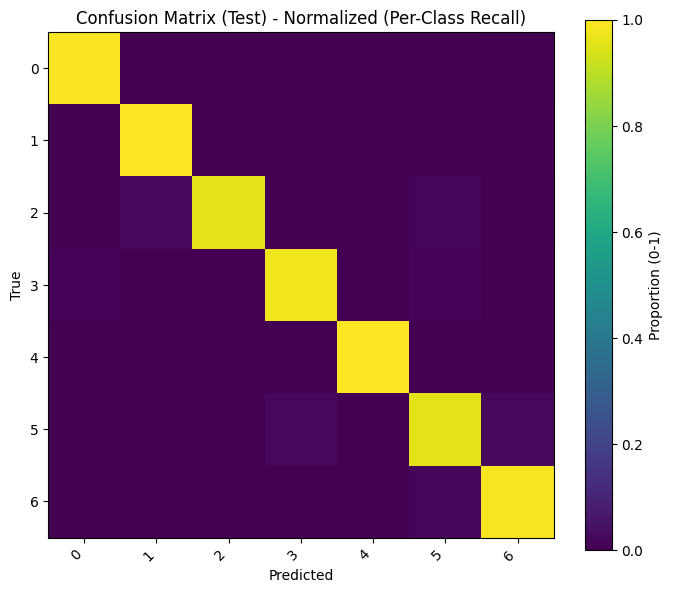


Sample misclassifications:
- True=0 (0) | Pred=6 (6) | Text: Add brian larsen to my digster sleep
- True=2 (2) | Pred=5 (5) | Text: Tell me the weather forecast for here in seven years
- True=2 (2) | Pred=1 (1) | Text: in Khlong Phraya Wildlife Sanctuary is there a cloud
- True=2 (2) | Pred=1 (1) | Text: What is the weather forecast for Yoakum , SC ?
- True=2 (2) | Pred=5 (5) | Text: What's the forecase for Inverness on February 5th, 2031 ?
- True=2 (2) | Pred=1 (1) | Text: Is it going to be sunny at five pm in Chatyrkul Wildlife Refuge
- True=2 (2) | Pred=6 (6) | Text: What is the weather forecast for Burundi
- True=2 (2) | Pred=1 (1) | Text: what is the forecast for Turtle Islands National Park
- True=2 (2) | Pred=5 (5) | Text: Play shadowplay by Dana on Deezer .
- True=3 (3) | Pred=5 (5) | Text: Play Brenda Kahn 's Rushall Station .


In [17]:
# Final evaluation: report + confusion matrix + misclassifications
# Build label names if available (otherwise numeric 0..C-1)
label_names = None
try:
    if "label" in ds["train"].features and hasattr(ds["train"].features["label"], "names"):
        label_names = ds["train"].features["label"].names
except:
    pass

if label_names is None:
    label_names = [str(i) for i in range(num_classes)]
    print("Label names not available; using numeric labels.")
else:
    print("Label names:", label_names)

# Get raw test texts (same order as ds["test"])
test_texts = list(ds["test"]["utterance"])

# Predict on test set (note: we used a loader that sorts within batches, but metrics are order-independent)
_, _, y_true, y_pred = eval_one_epoch_packed(model2, test_loader2, criterion2)

print("\nFinal Accuracy:", accuracy_score(y_true, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=label_names, digits=4))

cm = confusion_matrix(y_true, y_pred)

print("\nConfusion Matrix:\n", cm)

# Plot normalized confusion matrix (per-class recall)
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(7,6))
plt.imshow(cm_norm, vmin=0, vmax=1, interpolation="nearest")
plt.title("Confusion Matrix (Test) - Normalized (Per-Class Recall)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(range(num_classes), label_names, rotation=45, ha="right")
plt.yticks(range(num_classes), label_names)
plt.colorbar(label="Proportion (0-1)")
plt.tight_layout()
plt.show()

# Misclassification samples (explain True vs Pred)
wrong_idx = np.where(np.array(y_true) != np.array(y_pred))[0][:10]
print("\nSample misclassifications:")
for i in wrong_idx:
    i = int(i)
    print(f"- True={y_true[i]} ({label_names[y_true[i]]}) | Pred={y_pred[i]} ({label_names[y_pred[i]]}) | Text: {test_texts[i][:120]}")


Iteration 1 – Baseline Vanilla RNN

What changed:
A baseline vanilla RNN classifier was implemented using fixed-length sequences via padding and truncation. The model consists of tokenisation, an embedding layer, a single-layer RNN, and a linear classification head that predicts one intent label from the final hidden state.

Why this design:
This iteration establishes a simple and correct baseline that is fully aligned with the module content. It follows the standard many-to-one sequence classification pipeline taught in Week 12 (RNN in PyTorch):
tokenise text → convert to embeddings → process with RNN → use the last hidden state → classify using a linear layer.
Using a vanilla RNN allows the core recurrent concept to be demonstrated without introducing more advanced architectures.

Observed results:
The training and validation curves show that the model is able to learn and converge, although convergence is relatively slower and training is less stable compared to later iterations. This behaviour is expected for a simple baseline model with limited capacity.

Iteration 2 – Improved Vanilla RNN

What changed:
Several improvements were introduced while keeping the architecture within the scope of the taught material:

Packed sequences using pack_padded_sequence to avoid unnecessary computation on padded tokens (as taught in Week 12 – RNN in PyTorch II).

Increased embedding dimension and hidden size to improve representation capacity.

Upgraded to a 2-layer vanilla RNN with dropout for better generalisation.

Hyperparameter tuning, including learning rate adjustment, weight decay, and a learning-rate scheduler.

The number of training epochs was increased to allow the higher-capacity model to converge more fully.

Why these changes help:
Packing sequences improves training efficiency and reduces the negative effect of padding on gradient updates. Increasing model capacity allows the RNN to capture more complex sequential patterns in text, while dropout helps reduce overfitting. Hyperparameter tuning further stabilises training and improves convergence.

Observed results:
Compared to Iteration 1, this model achieves higher validation accuracy with smoother and more stable training curves. The confusion matrix and misclassification analysis show that most predictions are correct, with remaining errors mainly arising from semantic overlap between intent classes.

Conclusion:
While the baseline vanilla RNN already performs well on SNIPS, the improved model with packed sequences and tuned hyperparameters achieves higher peak validation accuracy and more stable convergence.